# COVID-19 and Trump

## An exploratory analysis on the public's sentiment towards COVID-19 and President Trump.

As mentioned in the readme, this project serves as an introduction to NLP and Sentiment Analysis for myself. 

In this notebook, I have scraped tweets, consisting of keywords "coronavirus & trump" from Jan-1-2020 to May-1-2020, and attempt to address the following points:

- Besides the keywords, what are other frequent words in the gathered dataset? 
- How has the overall sentiment (regarding coronavirus & trump) changed over the last few months?

#### Note: For index to work, [view here](https://nbviewer.jupyter.org/github/mali875/Covid-19-and-Trump/blob/master/NLP_Twitter.ipynb).

## Index

- <font size="3px">[Scraping Twitter Data](#ref1)</font>
- <font size="3px">[Data Pre-Processing/Cleaning](#ref2)</font>
- <font size="3px">[Pre-Processing for Sentiment Analysis](#ref3)</font>
- <font size="3px">[Data Visualization](#ref4)</font>

In [1]:
"""
Importing libraries
"""

import logging
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from twitterscraper import query_tweets
from textblob import TextBlob
import nltk
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import warnings
from nltk.stem.porter import *
from wordcloud import WordCloud

INFO: {'User-Agent': 'Mozilla/5.0 (Windows NT 5.2; RW; rv:7.0a1) Gecko/20091211 SeaMonkey/9.23a1pre'}


<a id='ref1'></a>

### Scraping Twitter Data

Here, we gather our data:
- We use the twitterscraper module to scrape tweets.
- We scrape tweets from 2020-1-1 to 2020-5-1
- We collect <=10k tweets per month.
- We append all data into a single dataframe.

In [2]:
"""
Module used: https://github.com/taspinar/twitterscraper
Getting twitter data on 'coronavirus & Trump' form Jan-May.
"""

limit = 10000
lang = 'english'
jan = dt.date(2020,1,1)
feb = dt.date(2020,2,1)
march = dt.date(2020,3,1)
april = dt.date(2020,4,1)
may = dt.date(2020,5,1)

query = "coronavirus & Trump"
tweets_jan = query_tweets(query, begindate=jan, enddate=feb, limit=limit, lang=lang)  #Jan-Feb
tweets_feb = query_tweets(query, begindate=feb, enddate=march, limit=limit, lang=lang) #Feb-March
tweets_march = query_tweets(query, begindate=march, enddate=april, limit=limit, lang=lang) #March-April
tweets_april = query_tweets(query, begindate=april, enddate=may, limit=limit, lang=lang) #April-May

INFO: queries: ['coronavirus & Trump since:2020-01-01 until:2020-01-02', 'coronavirus & Trump since:2020-01-02 until:2020-01-04', 'coronavirus & Trump since:2020-01-04 until:2020-01-05', 'coronavirus & Trump since:2020-01-05 until:2020-01-07', 'coronavirus & Trump since:2020-01-07 until:2020-01-08', 'coronavirus & Trump since:2020-01-08 until:2020-01-10', 'coronavirus & Trump since:2020-01-10 until:2020-01-11', 'coronavirus & Trump since:2020-01-11 until:2020-01-13', 'coronavirus & Trump since:2020-01-13 until:2020-01-14', 'coronavirus & Trump since:2020-01-14 until:2020-01-16', 'coronavirus & Trump since:2020-01-16 until:2020-01-18', 'coronavirus & Trump since:2020-01-18 until:2020-01-19', 'coronavirus & Trump since:2020-01-19 until:2020-01-21', 'coronavirus & Trump since:2020-01-21 until:2020-01-22', 'coronavirus & Trump since:2020-01-22 until:2020-01-24', 'coronavirus & Trump since:2020-01-24 until:2020-01-25', 'coronavirus & Trump since:2020-01-25 until:2020-01-27', 'coronavirus & 

In [5]:
"""
Join monthly datasets into one dataframe.
"""

tweets_months_list = [tweets_jan, tweets_feb, tweets_march, tweets_april]

tweetsdf = pd.DataFrame()
for tweets_month in tweets_months_list:
    tweetsdf = tweetsdf.append(pd.DataFrame(t.__dict__ for t in tweets_month))   
    
tweetsdf.index = range(len(tweetsdf)) #Reset index
print("Shape:", tweetsdf.shape)
tweetsdf.head(3)

Shape: (15029, 21)


,screen_name,username,user_id,tweet_id,tweet_url,timestamp,timestamp_epochs,text,text_html,links,...,has_media,img_urls,video_url,likes,retweets,replies,is_replied,is_reply_to,parent_tweet_id,reply_to_users
0,DanButcher2,Dan Butcher,518670571,1218572615616430080,/DanButcher2/status/1218572615616430080,2020-01-18 16:35:26,1579365326,From The Economist Espresso: Defiance from #Ir...,"<p class=""TweetTextSize js-tweet-text tweet-te...",[https://espresso.economist.com/2d2959e82e89b6...,...,False,[],,0,0,0,False,False,,[]
1,dafyddmihangel,Dafydd Mihangel (Crach Ffinnant)〓〓,47906764,1218440425205354497,/dafyddmihangel/status/1218440425205354497,2020-01-18 07:50:09,1579333809,Donald Trump threatens to slap Tariffs on Coro...,"<p class=""TweetTextSize js-tweet-text tweet-te...",[],...,False,[],,1,0,0,False,False,,[]
2,DanButcher2,Dan Butcher,518670571,1218572615616430080,/DanButcher2/status/1218572615616430080,2020-01-18 16:35:26,1579365326,From The Economist Espresso: Defiance from #Ir...,"<p class=""TweetTextSize js-tweet-text tweet-te...",[https://espresso.economist.com/2d2959e82e89b6...,...,False,[],,0,0,0,False,False,,[]


<a id='ref2'></a>

### Data Pre-Processing/Cleaning

Here, we take the following steps:
- Removing tweets from "bitcoinconnect" to avoid bias.
- Convert all words to lowercase.
- Remove all hyperlinks from all tweets.
- Remove all mentions from all tweets (i.e @username).
- Remove special characters from all tweets.
- Remove all duplicates from our dataframe.
- Tokenization followed by Stemming using the PorterStemmer technique from NLTK.

In [13]:
"""
Most tweets from: https://twitter.com/bitcoinconnect?lang=en
In order to avoid bias in our results, these tweets are removed.
"""
display(tweetsdf["screen_name"].value_counts())
tweetsdf["screen_name"] = tweetsdf["screen_name"].astype(str)
print("Data shape before removing:", tweetsdf.shape)
tweetsdf = tweetsdf[tweetsdf["screen_name"] !="bitcoinconnect"]
print("Data shape after removing", tweetsdf.shape)

bitcoinconnect     2460
JanetWa94118686      72
TopTwoNewsWords      68
Trump_Recession      27
SiteFocusHQ          21
                   ... 
ftwittwer1            1
Nan33S                1
fradarl29             1
FileJ_ExE             1
C6WolfEnergy          1
Name: screen_name, Length: 9717, dtype: int64

Data shape before removing: (15029, 21)
Data shape after removing (12569, 21)


In [14]:
"""
CleanTweets() does the following:
- Converts tweet to lower case.
- Removes all links.
- Removes all mentions, i.e @usernames.

"""

def CleanTweets(tweet):
    tweet = tweet.lower()         #Convert to lowercase.
    
    cleanedlist = [word for word in tweet.split() if 'http' not in word]     #Remove hyperlinks
    cleanedtext = ' '.join(cleanedlist)

    #removing  mentions
    r = re.findall(r'@[\w]*', cleanedtext) 
    for i in r:
        cleanedtext = re.sub(i, '', cleanedtext)
        
    return cleanedtext

In [17]:
"""
Here, we do the following:
- Drop all duplicates form our dataset.
- Apply CleanTweets() to all Tweets.
- Remove all special characters from all tweets.

Considerations: 
- Removing short words (<= 3 charachters)?
- Removing hashtags?
"""

#Dropping duplicates
tweetsdf.drop_duplicates(["username","text"],inplace=True)

#Reindexing
tweetsdf.index = range(len(tweetsdf))

#CleanedTweets
tweetsdf["CleanedTweets"] = np.vectorize(CleanTweets)(tweetsdf["text"])

#Removing special characters
tweetsdf['CleanedTweets'] = tweetsdf['CleanedTweets'].str.replace("[^a-zA-Z]", " ")

In [18]:
print("Shape:",tweetsdf.shape)
tweetsdf.loc[:,["text","CleanedTweets"]].head()

Shape: (11617, 22)


,text,CleanedTweets
0,From The Economist Espresso: Defiance from #Ir...,from the economist espresso defiance from ir...
1,Donald Trump threatens to slap Tariffs on Coro...,donald trump threatens to slap tariffs on coro...
2,"Jan2020 leap yr ,Trump/versus impeachment he b...",jan leap yr trump versus impeachment he b...
3,we’re TEN days into 2020\n\n- trump is tryna i...,we re ten days into trump is tryna init...
4,When it comes to epidemics\nTrump can only scr...,when it comes to epidemics trump can only scre...


In [19]:
"""
- Tokenization
- Stemming using PorterStemmer
"""

#Tokenize all tweets
tokenized_tweet = tweetsdf['CleanedTweets'].apply(lambda x: x.split())

#Stemming
stemmer = PorterStemmer()
tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x])

tokenized_tweet.head()

0    [from, the, economist, espresso, defianc, from...
1    [donald, trump, threaten, to, slap, tariff, on...
2    [jan, leap, yr, trump, versu, impeach, he, bec...
3    [we, re, ten, day, into, trump, is, tryna, ini...
4    [when, it, come, to, epidem, trump, can, onli,...
Name: CleanedTweets, dtype: object

In [20]:
"""
- Untokenizing
"""

for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])

tweetsdf['ProcessedTweets'] = tokenized_tweet
tweetsdf['ProcessedTweets'].head(3)

0    from the economist espresso defianc from iran ...
1    donald trump threaten to slap tariff on corona...
2    jan leap yr trump versu impeach he becom more ...
Name: ProcessedTweets, dtype: object

<a id='ref3'></a>

### Pre-Processing for Sentiment Analysis

Here, we take the following steps:
- Use the vader sentiment analysis tool.
- Tweets are labeled positive/negative based on compound score.
- Seperate dataframe into monthly datasets.
- Filter out keywords & stopwords from tweets.

In [21]:
"""
GetSentiment() returns the overall sentiment of the tweet.
- We add a Sentiment column to our dataset.
"""

def GetSentiment(sentence, sid_obj):
    sentiment_dict = sid_obj.polarity_scores(sentence)
    if sentiment_dict['compound'] >= 0.05 : 
        return 1
    elif sentiment_dict['compound'] < - 0.05 : 
        return -1
    else:
        return 0


sid_obj = SentimentIntensityAnalyzer()
tweetsdf["Sentiment"] = np.vectorize(GetSentiment)(tweetsdf["ProcessedTweets"], sid_obj)
tweetsdf.loc[:,["CleanedTweets","ProcessedTweets","Sentiment"]].head()

,CleanedTweets,ProcessedTweets,Sentiment
0,from the economist espresso defiance from ir...,from the economist espresso defianc from iran ...,1
1,donald trump threatens to slap tariffs on coro...,donald trump threaten to slap tariff on corona...,-1
2,jan leap yr trump versus impeachment he b...,jan leap yr trump versu impeach he becom more ...,1
3,we re ten days into trump is tryna init...,we re ten day into trump is tryna initi ww a n...,-1
4,when it comes to epidemics trump can only scre...,when it come to epidem trump can onli screw up...,1


In [22]:
"""
GetMonthlyDf() returns a subset of the original dataset between
specified startdate and enddate.
- We seperate data into monthly datasets.
"""

def GetMonthlyDf(df, startdate, enddate):
    startdate = dt.datetime(startdate.year, startdate.month, startdate.day) #Converting date to datetime
    enddate = dt.datetime(enddate.year, enddate.month, enddate.day)
    mask = (df['timestamp'] >= startdate) & (df['timestamp'] < enddate)
    return df[mask].copy(deep=True)

#Original data sorted by datetimes.
sorted_tweetsdf = tweetsdf.sort_values("timestamp")

#Get monthly data
jan_df = GetMonthlyDf(sorted_tweetsdf, jan, feb)
feb_df = GetMonthlyDf(sorted_tweetsdf, feb, march)
march_df = GetMonthlyDf(sorted_tweetsdf, march, april)
april_df = GetMonthlyDf(sorted_tweetsdf, april, may)

In [23]:
"""
ignoreWords() is used to filter out keywords/stop words.
This allows us to look at other hidden patterns.
"""

def ignoreWords(tweet):
    ignore_words = ["viru","#viru","coronaviru","#coronaviru","twitter","trump","#trump",
                   "the","he","is","on","need","go","to","want","see","detail","pic"]
    cleanedlist = [x for x in tweet.split() if x not in ignore_words]
    cleanedtext = ' '.join(cleanedlist)
    return cleanedtext

sorted_tweetsdf["RefinedTweets"] = np.vectorize(ignoreWords)(sorted_tweetsdf["ProcessedTweets"])
jan_df["RefinedTweets"] = np.vectorize(ignoreWords)(jan_df["ProcessedTweets"])
feb_df["RefinedTweets"] = np.vectorize(ignoreWords)(feb_df["ProcessedTweets"])
march_df["RefinedTweets"] = np.vectorize(ignoreWords)(march_df["ProcessedTweets"])
april_df["RefinedTweets"] = np.vectorize(ignoreWords)(april_df["ProcessedTweets"])

<a id='ref4'></a>

### Data Visualization

1. Wordclouds for the following:
    - Overall dataset with & without filtering keywords & stopwords.
    - Repeat for monthly datasets jan_df, feb_df, march_df, april_df.
2. Sentimet value plots

In [37]:
"""
WordCloud() generates a word cloud based on the df and column passed.
"""
def genWordCloud(df, col):
    all_words = ' '.join([text for text in df[col]])
    wordcloud = WordCloud(width=1000, height=800, random_state=21, max_font_size=110).generate(all_words)
    plt.figure(figsize=(10, 10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()

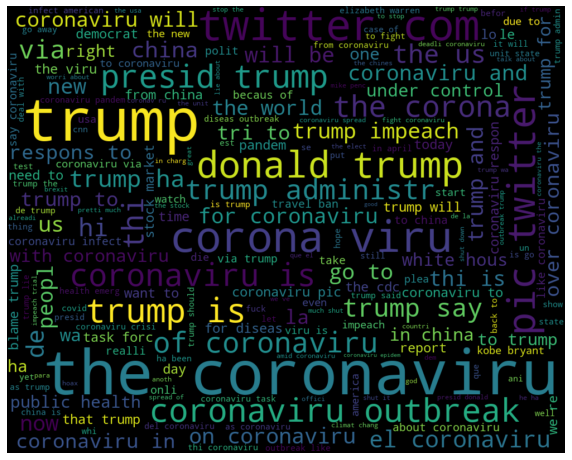

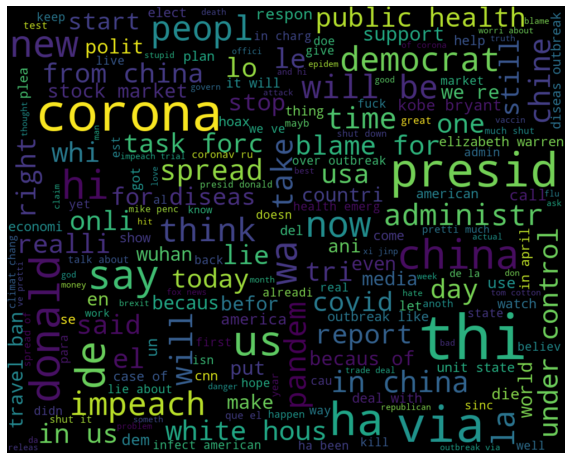

In [38]:
"""
- Overall dataset w & w/o key/stop-words
"""
genWordCloud(sorted_tweetsdf,"ProcessedTweets")
genWordCloud(sorted_tweetsdf,"RefinedTweets")

Interesting words: China, Stock market, Impeach, Under control, travel ban, democrat, blame.

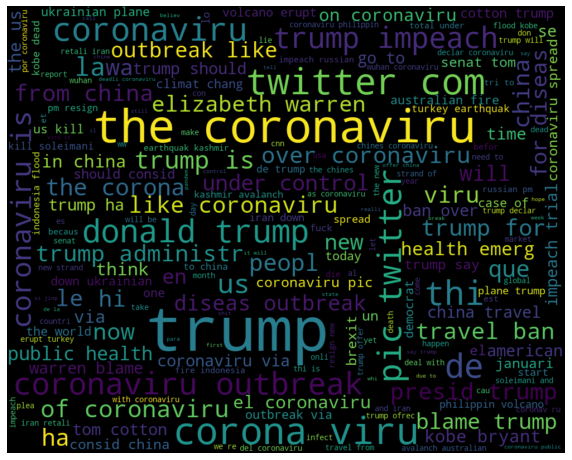

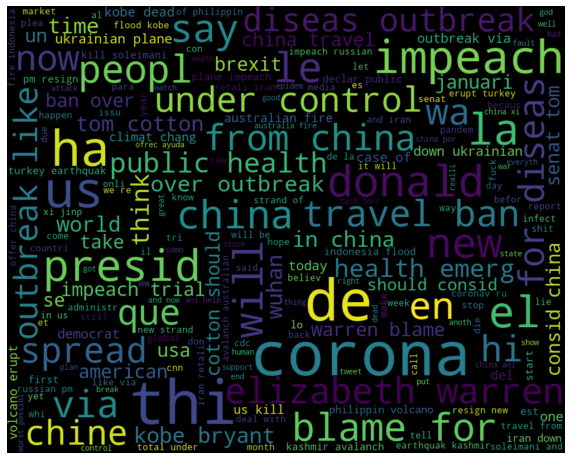

In [26]:
"""
- Jan dataset w & w/o key/stop-words
"""
genWordCloud(jan_df,"ProcessedTweets")
genWordCloud(jan_df,"RefinedTweets")

Interesting words: Elizabeth Warren, impeach trial, public health, disease outbreak, travel ban, health emergecy.

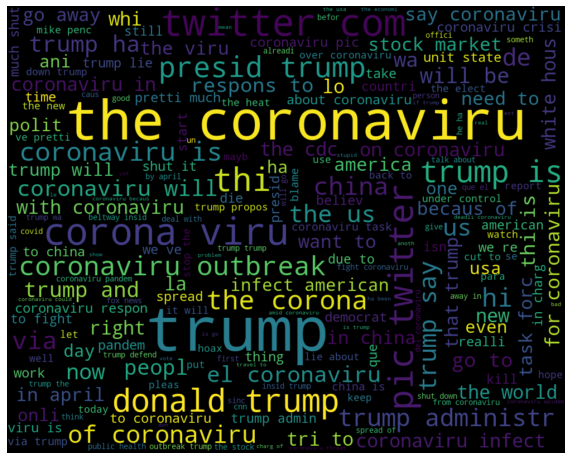

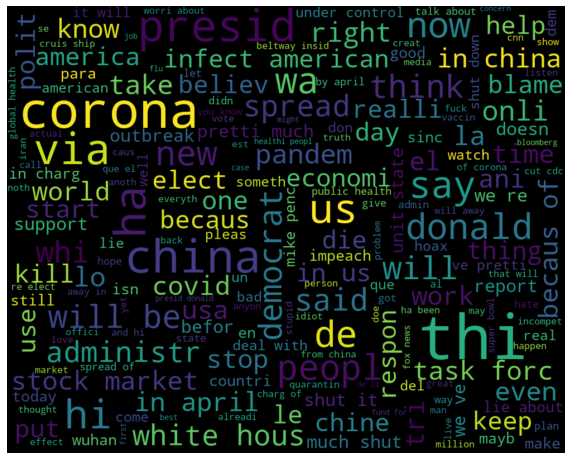

In [28]:
"""
- Feb dataset w & w/o key/stop-words
"""
genWordCloud(feb_df,"ProcessedTweets")
genWordCloud(feb_df,"RefinedTweets")

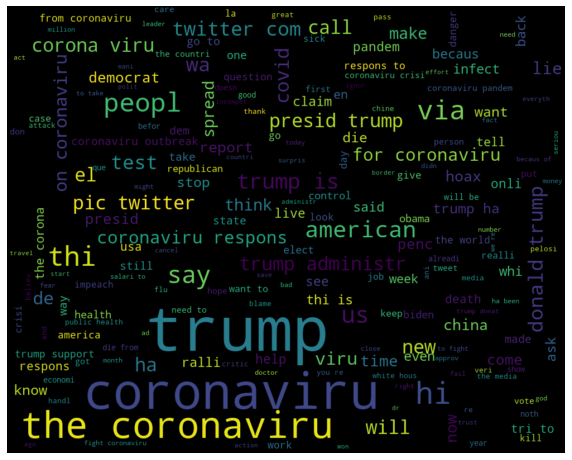

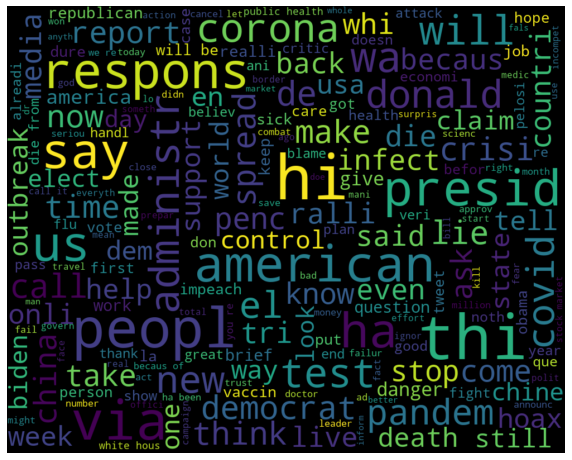

In [29]:
"""
- March dataset w & w/o key/stop-words
"""
genWordCloud(march_df,"ProcessedTweets")
genWordCloud(march_df,"RefinedTweets")

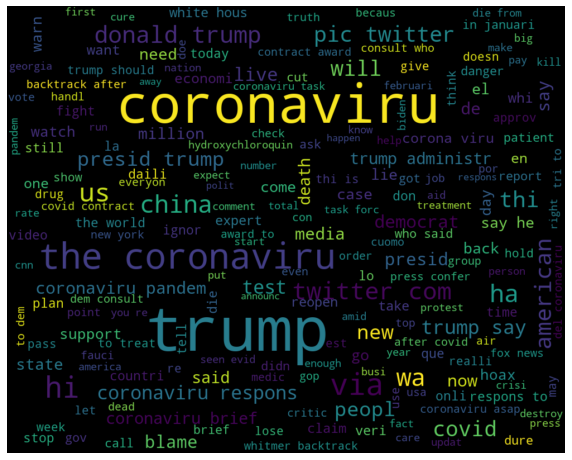

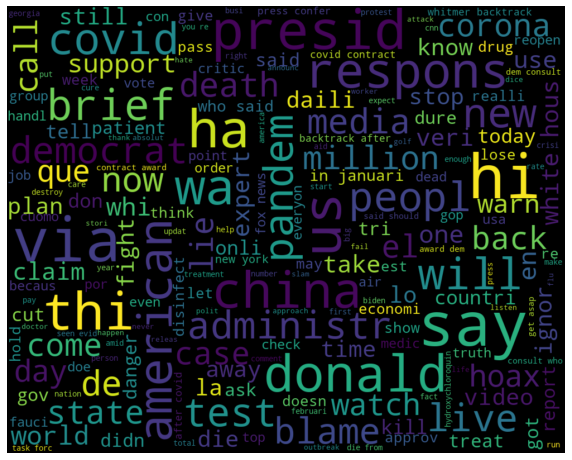

In [30]:
"""
- April dataset w & w/o key/stop-words
"""
genWordCloud(april_df,"ProcessedTweets")
genWordCloud(april_df,"RefinedTweets")

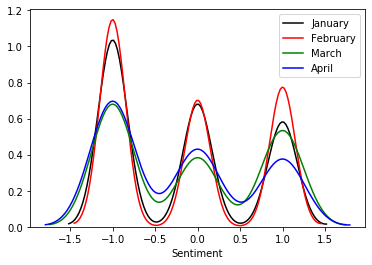

In [34]:
sns.distplot(jan_df['Sentiment'], hist = False, label = 'January',color= 'black')
sns.distplot(feb_df['Sentiment'], hist = False, label = 'February',color= 'red')
sns.distplot(march_df['Sentiment'], hist = False, label = 'March',color= 'green')
sns.distplot(april_df['Sentiment'], hist = False, label = 'April',color= 'blue')

In [ ]:
#Reference: 
#Advanced Query: https://twitter.com/search-advanced?lang=en
#Search Operators: https://lifehacker.com/search-twitter-more-efficiently-with-these-search-opera-1598165519